<a href="https://colab.research.google.com/github/jamestheengineer/data-science-from-scratch-Python/blob/master/Chapter_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Only do this once per VM, otherwise you'll get multiple clones and nested directories
!git clone https://github.com/jamestheengineer/data-science-from-scratch-Python.git
%cd data-science-from-scratch-Python/
!pip install import-ipynb

In [0]:
# k-Nearest Neighbors
from typing import List
from collections import Counter

def raw_majority_vote(labels: List[str]) -> str:
  votes= Counter(labels)
  winner, _ = votes.most_common(1)[0]
  return winner

assert raw_majority_vote(['a','b','c','b']) == 'b'

In [0]:
# The previous function doesn't handle ties. Let's reduce k until we find a unique winner
def majority_vote(labels: List[str]) -> str:
  """Assumes that labels are ordered from nearest to farthest."""
  vote_counts = Counter(labels)
  winner, winner_count = vote_counts.most_common(1)[0]
  num_winners = len([count
                     for count in vote_counts.values()
                     if count == winner_count])
  if num_winners == 1:
    return winner
  else:
    return majority_vote(labels[:-1]) # try again without the farthest

# Tie, so look at first 4
assert majority_vote(['a','b','c','b','a']) == 'b'

In [0]:
from typing import NamedTuple
import import_ipynb
from Chapter_4 import Vector, distance

class LabeledPoint(NamedTuple):
  point: Vector
  label: str

def knn_classify(k: int,
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:
    # Order the labeled points from nearest to farthest
    by_distance = sorted(labeled_points,
                         key=lambda lp: distance(lp.point, new_point))
    
    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    # And let them vote
    return majority_vote(k_nearest_labels)

In [0]:
# Let's do an example
import requests

data = requests.get(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
)

with open('iris.dat', 'w') as f:
  f.write(data.text)

print(data.text)

In [0]:


from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row: List[str]) -> LabeledPoint:
  """
  sepal_length, sepal_width, petal_length, petal_width, class
  """
  measurements = [float(value) for value in row[:-1]]
  # Class is e.g., "Iris-virginica"; we just want "virginica"
  label = row[-1].split("-")[-1]

  return LabeledPoint(measurements, label)

with open('iris.dat') as f:
  reader = csv.reader(f)
  print(row_count)
  iris_data = [parse_iris_row(row) for row in reader if any(row)]
  print(len(iris_data))
 
# We'll also group just the points by species/label so we can plot them
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
  points_by_species[iris.label].append(iris.point)

In [0]:
# Let's plot
from matplotlib import pyplot as plt
metrics = ['sepal length', 'sepal width','petal length','petal width']
pairs = [(i,j) for i in range(4) for j in range(4) if i < j]
print(pairs)
marks = ['+','.','x'] # we have 3 classes, so 3 markers

fig, ax = plt.subplots(2,3)

for row in range(2):
  for col in range(3):
    i, j = pairs[3 * row + col]
    ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])
    
    for mark, (species, points) in zip(marks, points_by_species.items()):
        xs = [point[i] for point in points]
        ys = [point[j] for point in points]
        ax[row][col].scatter(xs, ys, marker=mark, label=species)
    
ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()

In [0]:
# Plots make it seem like we should be able to kNN this, so let's do it
import random
from Chapter_11 import split_data

random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)
assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

In [0]:
from typing import Tuple

# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
  predicted = knn_classify(5, iris_train, iris.point)
  actual = iris.label

  if predicted == actual:
    num_correct += 1

  confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix) # Only misses 1.

In [41]:
# Curse of Dimensionality
def random_point(dim: int) -> Vector:
  return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
  return [distance(random_point(dim), random_point(dim))
          for _ in range(num_pairs)]

# For every dimension from 1 to 100, we'll compute 10,000 distances and use
# those to compute the average distance between points and the minimum distance 
# between points in each dimension
import tqdm

dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
  distances = random_distances(dim, 10000) # 10,000 random pairs
  avg_distances.append(sum(distances) / 10000) # track the average
  min_distances.append(min(distances)) # track the minimum

min_avg_ratio = [min_dist / avg_dist
                     for min_dist, avg_dist in zip(min_distances, avg_distances)] 



Curse of Dimensionality: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


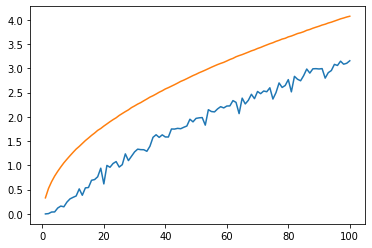

In [43]:
plt.plot(dimensions, min_distances, dimensions, avg_distances)

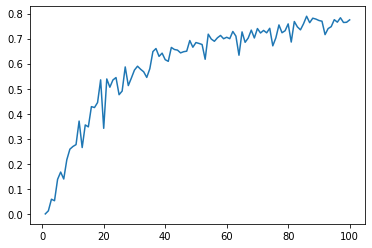

In [44]:
plt.plot(dimensions, min_avg_ratio)